In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import datasets
from sklearn.model_selection import train_test_split , KFold
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier



from surprise.model_selection import train_test_split, cross_validate
from surprise import SVD, Reader, Dataset


from load_csv import Dataset as Dataset_Classe #Per diferenciar de la funció Dataset de surprise


import numpy as np
from surprise import SVD, KNNBasic, Dataset, Reader
from surprise.model_selection import KFold
from surprise import accuracy

In [77]:
"""dataframe = Dataset_Classe()
dataframe.load_dataset()
dataframe.clear_dataset()
df = dataframe.get_dataset()"""

df = pd.read_csv("C:/Users/Joel/Documents/UAB/Tercer/Primer_Semestre/AC - Aprenentatge Computacional/Projecte/ratings_Electronics.csv",
                             names=['userId', 'productId','rating','timestamp'])

In [78]:
df_save = df
df = df_save
print(df.head())

           userId   productId  rating   timestamp
0   AKM1MP6P0OYPR  0132793040     5.0  1365811200
1  A2CX7LUOHB2NDG  0321732944     5.0  1341100800
2  A2NWSAGRHCP8N5  0439886341     1.0  1367193600
3  A2WNBOD3WNDNKT  0439886341     3.0  1374451200
4  A1GI0U4ZRJA8WN  0439886341     1.0  1334707200


In [79]:
print("Total Reviews:",df.shape[0])
print("Total Columns:",df.shape[1])

Total Reviews: 7824482
Total Columns: 4


In [81]:
# Estadístiques dels ratings
print("\nEstadístiques dels ratings:")
print("Minimum rating:", df["rating"].min())
print("Maximum rating:", df["rating"].max())


Estadístiques dels ratings:
Minimum rating: 1.0
Maximum rating: 5.0


In [82]:
print("Total number of ratings :",df.rating.nunique())
print("Total number of users   :", df.userId.nunique())
print("Total number of products  :", df.productId.nunique())

Total number of ratings : 5
Total number of users   : 4201696
Total number of products  : 476002


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [84]:
# Check missing value
df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [85]:
# Check Duplicate data
df[df.duplicated()].any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

In [86]:
# rating describe summary 
df.describe()['rating']

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

In [87]:
print("Unique value of Rating:",df.rating.unique())

Unique value of Rating: [5. 1. 3. 2. 4.]


In [88]:
# Find the minimum and maximum ratings
print('Minimum rating is: %d' %(df.rating.min()))
print('Maximum rating is: %d' %(df.rating.max()))

Minimum rating is: 1
Maximum rating is: 5


In [89]:
# Average rating of products
ratings = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings['ratings_count'] = pd.DataFrame(df.groupby('productId')['rating'].count())
ratings['ratings_average'] = pd.DataFrame(df.groupby('productId')['rating'].mean())
ratings.head(10)

,rating,ratings_count,ratings_average
productId,,,
0132793040,5.000000,1,5.000000
0321732944,5.000000,1,5.000000
0439886341,1.666667,3,1.666667
0511189877,4.500000,6,4.500000
0528881469,2.851852,27,2.851852
0558835155,3.000000,1,3.000000
059400232X,5.000000,3,5.000000
0594012015,2.000000,8,2.000000
0594017343,1.000000,1,1.000000


<Axes: >

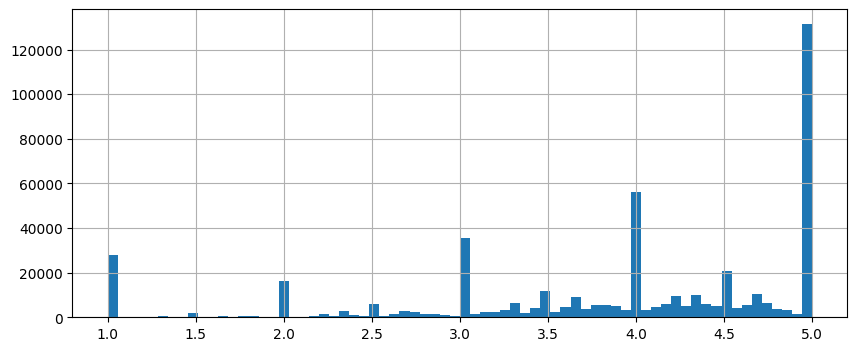

In [90]:
plt.figure(figsize=(10,4))
ratings['rating'].hist(bins=70)

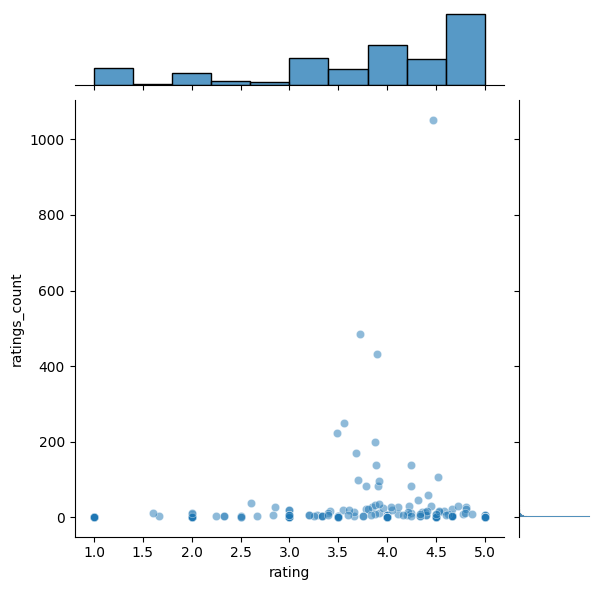

In [34]:
sns.jointplot(x='rating',y='ratings_count',data=ratings,alpha=0.5)

<Axes: xlabel='productId'>

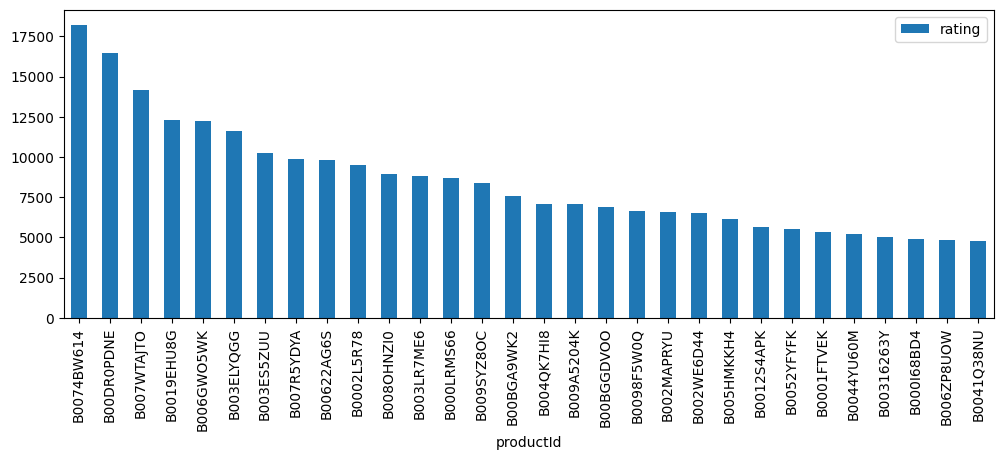

In [91]:
# Most top 30 products
popular_products = pd.DataFrame(df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

In [ ]:
user_votes = pd.DataFrame(df.groupby('userId')['rating'].count())
users_filter = user_votes[user_votes['rating'] >= 50]

print("Usuarios con más de 50 votos:", users_filter.nunique())

items_votes = pd.DataFrame(df.groupby('productId')['rating'].count())
items_filter = items_votes[items_votes['rating'] >= 20]

print("Items con más de 5 votos:", items_filter.nunique())

Usuarios con más de 50 votos: rating    1540
dtype: int64
Items con más de 5 votos: rating    57791
dtype: int64


In [ ]:
# Users que passen el filtre
filtered_users = df[df['userId'].isin(users_filter.index)]

#Items que passen el filtre
filtered_dataset = filtered_users[filtered_users['productId'].isin(items_filter.index)]

#
print("Tamaño del dataset después de aplicar los filtros:")
print(filtered_dataset.shape)

print("Total number of ratings :",filtered_users.rating.nunique())
print("Total number of users   :", filtered_users.userId.nunique())
print("Total number of products  :", filtered_users.productId.nunique())

Tamaño del dataset después de aplicar los filtros:
(100643, 4)
Total number of ratings : 5
Total number of users   : 1540
Total number of products  : 48190


In [97]:
reader = Reader()
data = Dataset.load_from_df(filtered_dataset[['userId', 'productId', 'rating']], reader)

In [98]:
svd = SVD()
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9547  0.9669  0.9803  0.9622  0.9545  0.9637  0.0095  
MAE (testset)     0.7019  0.7133  0.7222  0.7097  0.7040  0.7102  0.0072  
Fit time          1.03    1.10    1.04    0.98    0.97    1.02    0.05    
Test time         0.07    0.07    0.08    0.07    0.07    0.07    0.00    


{'test_rmse': array([0.9546839 , 0.96693453, 0.98033888, 0.96220412, 0.95447307]),
 'test_mae': array([0.70187173, 0.71330863, 0.722152  , 0.709714  , 0.70399915]),
 'fit_time': (1.030531883239746,
  1.0950956344604492,
  1.0412135124206543,
  0.979856014251709,
  0.9690630435943604),
 'test_time': (0.06958699226379395,
  0.0676276683807373,
  0.07624363899230957,
  0.06894516944885254,
  0.06673717498779297)}

In [99]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [102]:
filtered_dataset['userId'].value_counts()

userId
ADLVFFE4VBT8      395
A3OXHLG6DIBRW8    375
A6FIAB28IS79      352
A5JLAU2ARJ0BO     329
A680RUE1FDO8B     325
                 ... 
A2C8I2RQ0WG940     20
AD8DLOGHAXL        19
AP2NZAALUQKF5      16
A16CVJUQOB6GIB     15
A3MV1KKHX51FYT      6
Name: count, Length: 1540, dtype: int64

In [103]:
# Check specific userId review
filtered_dataset[filtered_dataset['userId'] == 'A3LDPF5FMB782Z']

,userId,productId,rating,timestamp
1310,A3LDPF5FMB782Z,1400501466,5.0,1336003200
1588,A3LDPF5FMB782Z,1400501520,5.0,1362873600
1696,A3LDPF5FMB782Z,1400501776,5.0,1334102400
2502,A3LDPF5FMB782Z,140053271X,4.0,1310515200
3235,A3LDPF5FMB782Z,1400698987,4.0,1392854400
301916,A3LDPF5FMB782Z,B00009W3U9,4.0,1295913600
504686,A3LDPF5FMB782Z,B0002SQ0A4,4.0,1353888000
675474,A3LDPF5FMB782Z,B0009O6IXA,1.0,1295827200
950698,A3LDPF5FMB782Z,B000FSILBM,5.0,1295827200
977701,A3LDPF5FMB782Z,B000GT6HAM,2.0,1192579200


In [114]:
print(svd.predict('A3LDPF5FMB782Z', '1400501776'))
filtre = filtered_dataset[filtered_dataset['userId'] == 'A3LDPF5FMB782Z']
filtre[filtre['productId'] == '1400501776']['rating']

user: A3LDPF5FMB782Z item: 1400501776 r_ui = None   est = 4.31   {'was_impossible': False}


1696    5.0
Name: rating, dtype: float64